# 1. clean dataset

In [103]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


In [104]:
# read csv files
df_input1 = pd.read_csv('input1.csv', sep=';')
df_input2 = pd.read_csv('input2.csv', sep=';')
df_target = pd.read_csv('target.csv', sep=';')

print(df_input1.shape) #(27936, 6)
print(df_input2.shape) #(1164, 2)
print(df_target.shape) #(1463, 2)

(27936, 6)
(1164, 2)
(1463, 2)


In [105]:
# discript inputs and outputs (to make sure that there is no missing data nor extreme outliers)
print(df_input2.describe())
print(df_input1.describe())
print(df_target.describe())


       DT_DEMO_Inlet_Brightness
count               1164.000000
mean                  83.407413
std                    2.588630
min                   74.675075
25%                   81.789047
50%                   83.342828
75%                   85.090774
max                   91.451909
       DT_DEMO_InletPressure  DT_DEMO_Temperature    DT_DEMO_PH  \
count           27936.000000         27936.000000  27936.000000   
mean              850.234605            70.001295     10.687645   
std                 6.677961             0.376114      0.217029   
min               827.762023            68.760701      9.877040   
25%               845.684225            69.744680     10.539314   
50%               850.285487            70.000294     10.686459   
75%               854.864148            70.259245     10.835738   
max               874.359938            71.493898     11.450929   

       DT_DEMO_Peroxide  DT_DEMO_Soda  
count      27936.000000  27936.000000  
mean          20.063679     

In [106]:
# the first column is the time stamp
df_input1['time_stamp'] = pd.to_datetime(df_input1["Unnamed: 0"], format='%d.%m.%Y %H:%M')
df_input2['time_stamp'] = pd.to_datetime(df_input2["Unnamed: 0"], format='%d.%m.%Y %H:%M')
df_target['time_stamp'] = pd.to_datetime(df_target["Unnamed: 0"], format='%d.%m.%Y %H:%M')
df_input1 = df_input1.drop(columns=["Unnamed: 0"])
df_input2 = df_input2.drop(columns=["Unnamed: 0"])
df_target = df_target.drop(columns=["Unnamed: 0"])

# keep target data with date upto 2020-12-07 (as an output of data from input1 and input2)
df_target = df_target[df_target['time_stamp'] < '2020-12-08']

print(df_input1.shape) # (27936, 6)
print(df_input2.shape) # (1164, 2)
print(df_target.shape) # (1163, 2)

(27936, 6)
(1164, 2)
(1175, 2)


In [107]:
# check nan values
print(df_input1.isnull().sum())
print(df_input2.isnull().sum())
print(df_target.isnull().sum())

DT_DEMO_InletPressure    0
DT_DEMO_Temperature      0
DT_DEMO_PH               0
DT_DEMO_Peroxide         0
DT_DEMO_Soda             0
time_stamp               0
dtype: int64
DT_DEMO_Inlet_Brightness    0
time_stamp                  0
dtype: int64
DT_DEMO_Target_Brightness    0
time_stamp                   0
dtype: int64


# 2. construct df to train

In [108]:
#in input1, calculate the mean and std of the values every 2 hours, for example, the mean of the values from 00:00 to 02:00 should be the value of 00:00
df_input1_mean = df_input1.groupby(pd.Grouper(key='time_stamp', freq='2H')).mean()
df_input1_std = df_input1.groupby(pd.Grouper(key='time_stamp', freq='2H')).std()

#rename the columns, keep time_stamp, and all the others should be add "_mean" or "_std
df_input1_mean.columns = ['DT_DEMO_InletPressure_mean', 'DT_DEMO_Temperature_mean', 'DT_DEMO_PH_mean', 'DT_DEMO_Peroxide_mean', 'DT_DEMO_Soda_mean']
df_input1_std.columns = ['DT_DEMO_InletPressure_std', 'DT_DEMO_Temperature_std', 'DT_DEMO_PH_std', 'DT_DEMO_Peroxide_std', 'DT_DEMO_Soda_std']

df_input1 = pd.merge(df_input1_mean, df_input1_std, on='time_stamp', how='left')
df_input = pd.merge(df_input1, df_input2, on='time_stamp', how='left')


In [109]:
# delay is an list of datetime objects, either 1h45, 3h45 or 5h45
propogation_delays = [   
    '01:45:00', 
    '03:45:00',
    '05:45:00',
]


In [110]:
# define a function if the nth row of a dataframe has the same date and time as the input, return n
def find_delay_index(time_stamp, df, on_col="time_stamp", return_col="DT_DEMO_Target_Brightness", delay=None):
    my_time = pd.to_datetime("2020-09-01 03:45:00", format='%Y-%m-%d %H:%M:%S')
    if delay is None:
        delay = '00:00:00'
    delay = pd.Timedelta(delay)
    time_stamp = time_stamp + delay
    if time_stamp == my_time:
        a = 1

    for i in range(len(df)):
        # print("=====================================")
        # print(df[on_col][i].date(),df[on_col][i].time())
        # print(time_stamp.date(),time_stamp.time())
        if df[on_col][i] == time_stamp:
            return df[return_col][i]
    return -1

def get_input_df(delay,df_input,df_target):
    df_input['target'] = [find_delay_index(df_input['time_stamp'][i], df_target, delay=delay) for i in range(len(df_input))]
    df_input = df_input[df_input["target"]!=-1]
    return df_input

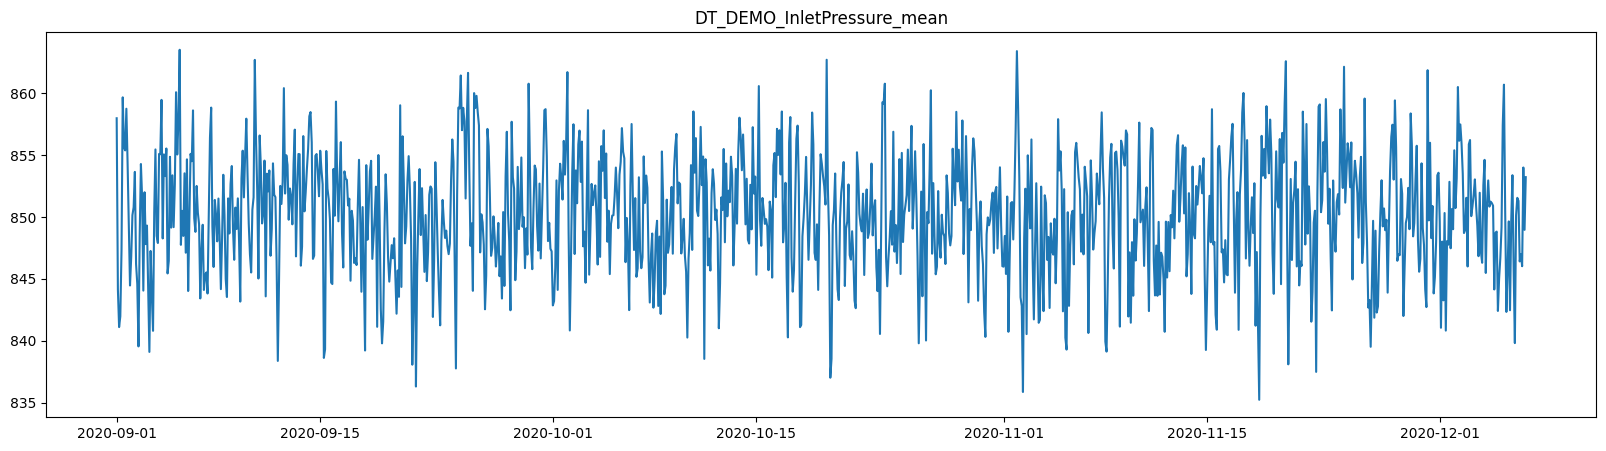

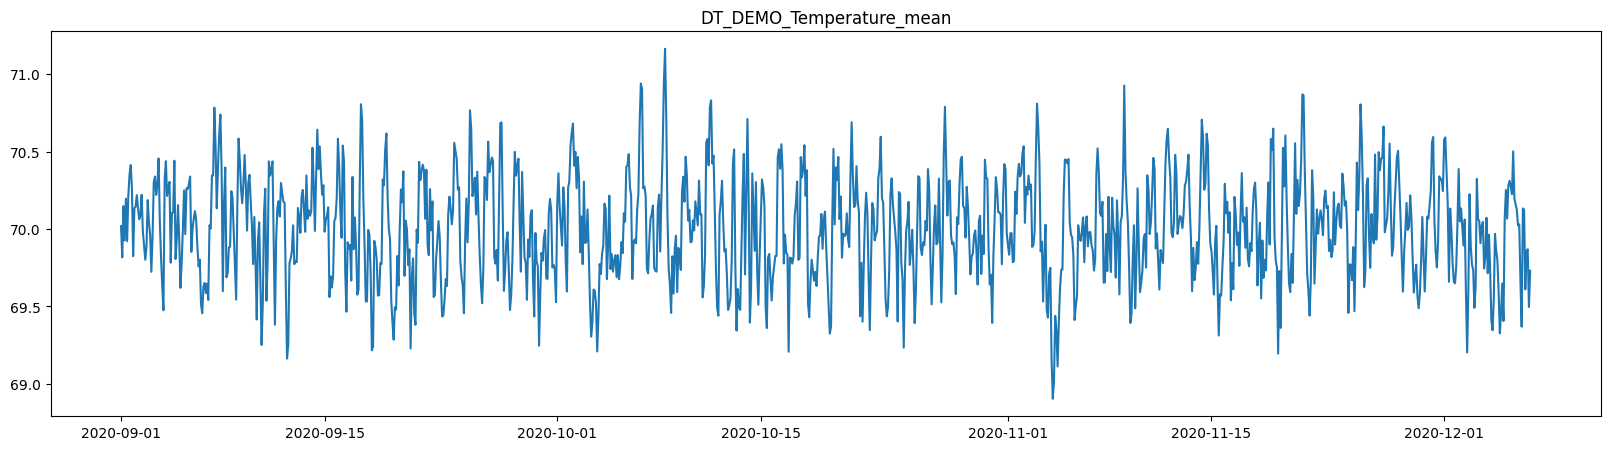

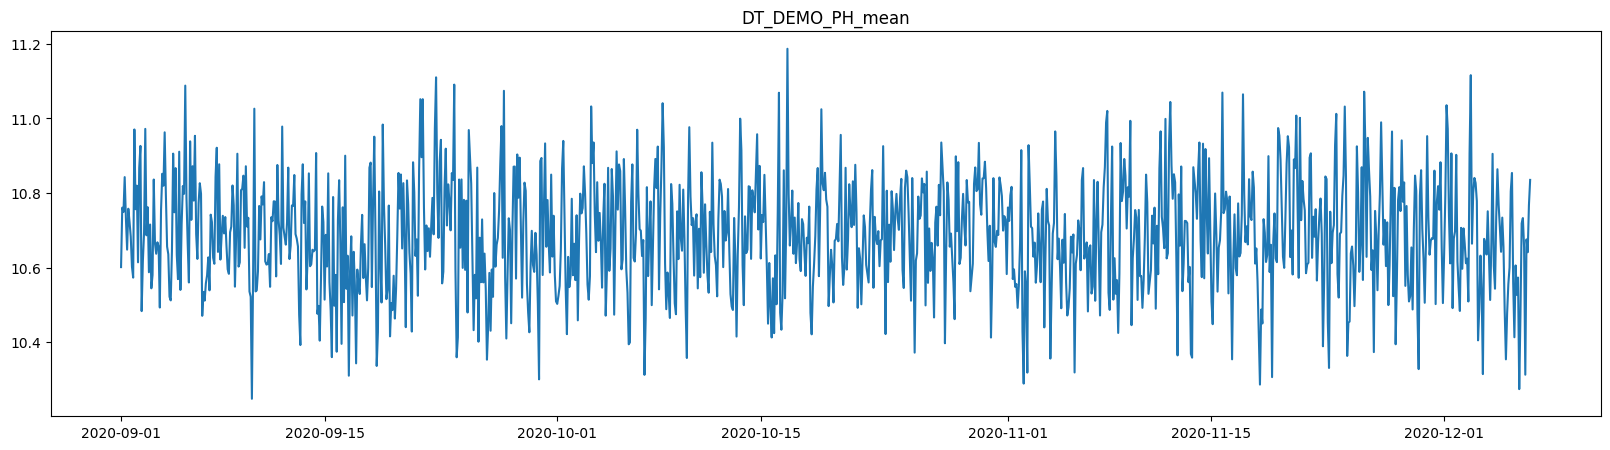

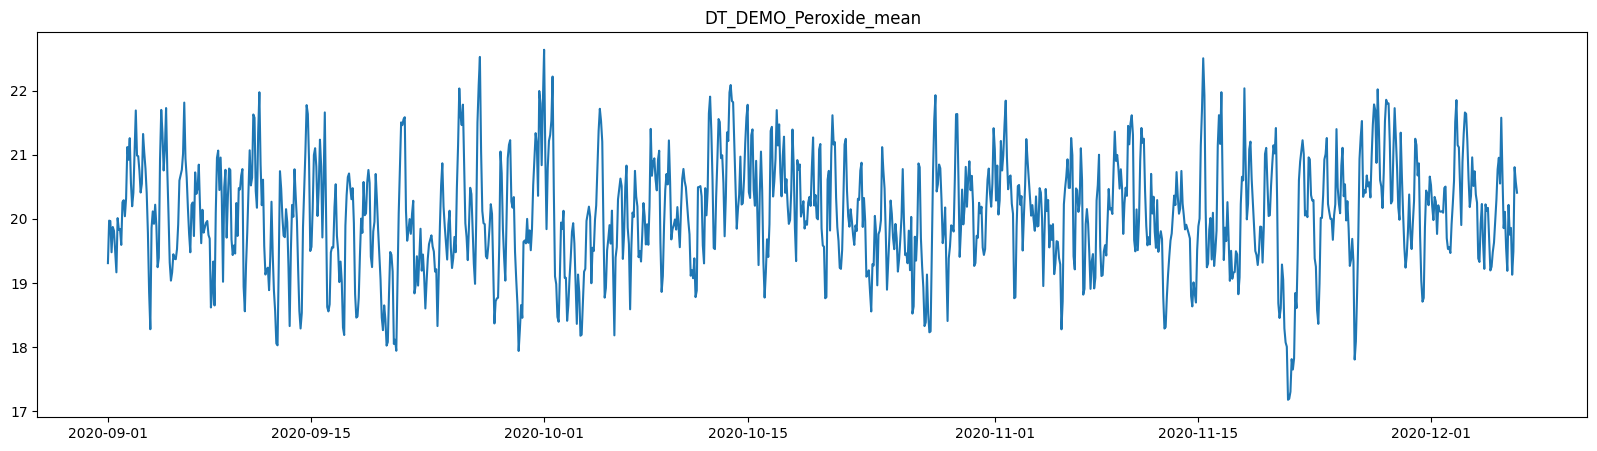

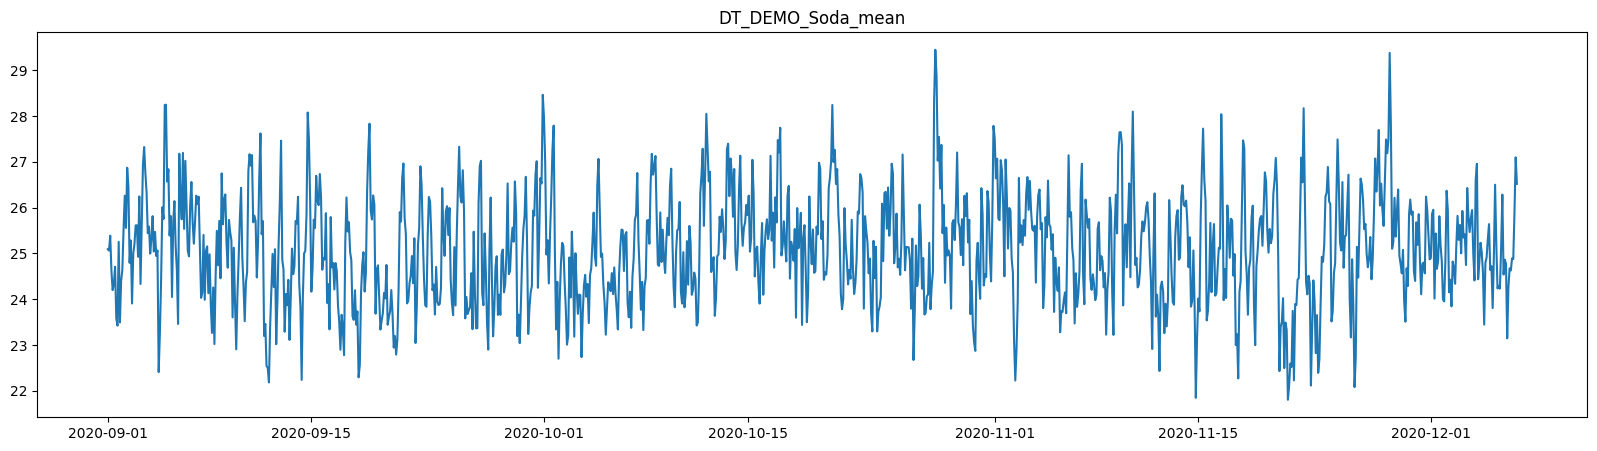

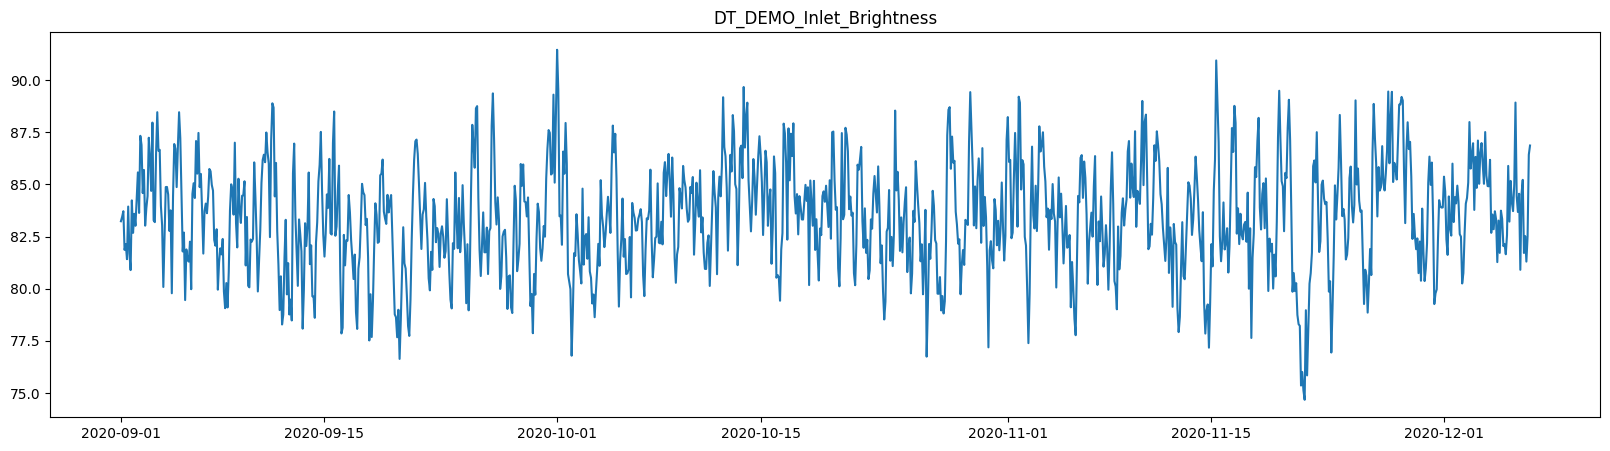

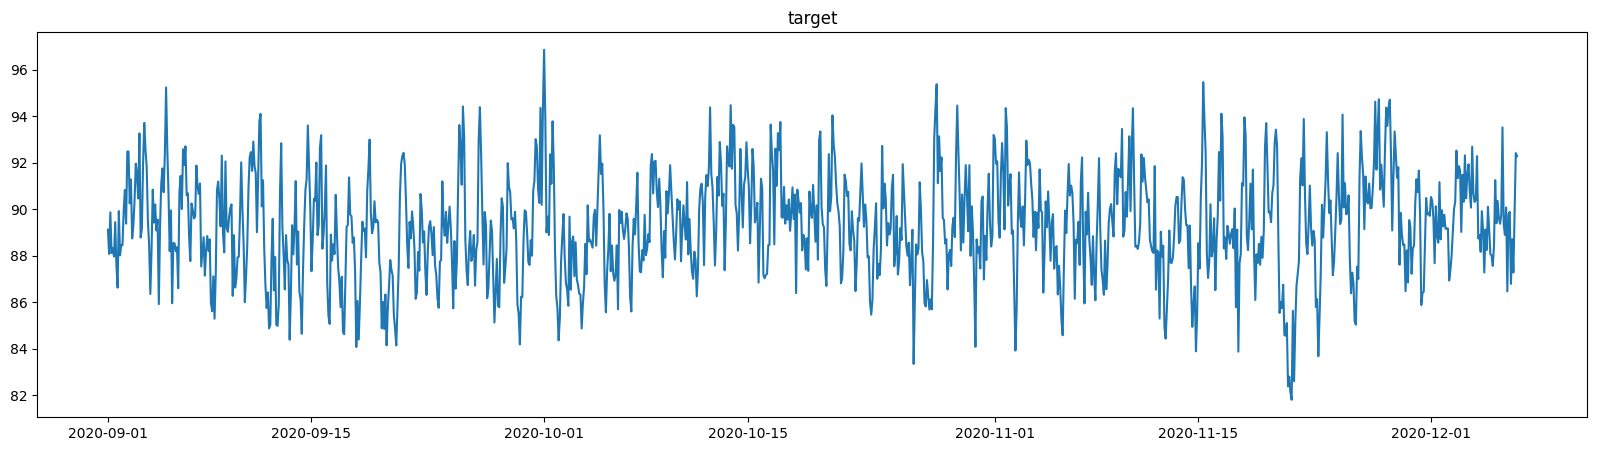

In [113]:
# to draw the time series plot 
df_input = get_input_df(propogation_delays[1],df_input,df_target)

def draw_time_series_plot(df_input, feature):
    plt.figure(figsize=(20, 5))
    plt.plot(df_input["time_stamp"], df_input[feature])
    plt.title(feature)
    plt.show()

# draw time series plot of each feature
draw_time_series_plot(df_input, 'DT_DEMO_InletPressure_mean')
draw_time_series_plot(df_input, 'DT_DEMO_Temperature_mean')
draw_time_series_plot(df_input, 'DT_DEMO_PH_mean')
draw_time_series_plot(df_input, 'DT_DEMO_Peroxide_mean')
draw_time_series_plot(df_input, 'DT_DEMO_Soda_mean')
draw_time_series_plot(df_input, 'DT_DEMO_Inlet_Brightness')
draw_time_series_plot(df_input, 'target')

# train a machine learning network

In [68]:
# train test split with random state 42
def split_dataset(df_input):
    df_input.drop(columns=['time_stamp'], inplace=True)
    df_train, df_test = train_test_split(df_input, test_size=0.2, random_state=42)
    x_train = df_train.drop(columns=['target'])
    y_train = df_train['target']
    x_test = df_test.drop(columns=['target'])
    y_test = df_test['target']
    return x_train, y_train, x_test, y_test


In [43]:
# train a random forest regressor as a baseline model

# define a function to calculate the metrics
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# define a function to train a random forest regressor
def train_rf(x_train, y_train, x_test, y_test, n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=random_state)
    rf.fit(x_train, y_train)
    y_pred_train = rf.predict(x_train)
    y_pred_test = rf.predict(x_test)
    mse_train, mae_train, r2_train = metrics(y_train, y_pred_train)
    mse_test, mae_test, r2_test = metrics(y_test, y_pred_test)
    return rf, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test

In [79]:
# first test which delay time is the best
train_results = []
test_results = []

for delay in propogation_delays:
    training_dataset = get_input_df(delay, df_input, df_target)
    x_train, y_train, x_test, y_test = split_dataset(training_dataset)
    rf, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test = train_rf(x_train, y_train, x_test, y_test)
    train_results.append([delay, mse_train, mae_train, r2_train])
    test_results.append([delay, mse_test, mae_test, r2_test])
    print("delay: ", delay)
    print("mse_train: ", mse_train)
    print("mae_train: ", mae_train)
    print("r2_train: ", r2_train)
    print("mse_test: ", mse_test)
    print("mae_test: ", mae_test)
    print("r2_test: ", r2_test)
    print("=====================================================")

C:\Users\taker\AppData\Local\Temp\ipykernel_6604\4194846493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input.drop(columns=['time_stamp'], inplace=True)


delay:  01:45:00
mse_train:  0.4286918727834552
mae_train:  0.5208597924392476
r2_train:  0.917614525761319
mse_test:  2.7374677947155823
mae_test:  1.3426082716098686
r2_test:  0.3551244957615125
delay:  03:45:00
mse_train:  0.025731905488296007
mae_train:  0.1274363442337257
r2_train:  0.995053007811645
mse_test:  0.1789510457490091
mae_test:  0.330651994362659
r2_test:  0.9581036251216997
delay:  05:45:00
mse_train:  0.21508656381966168
mae_train:  0.36759461496670304
r2_train:  0.9579664678048324
mse_test:  1.590846319490311
mae_test:  0.9737105986725313
r2_test:  0.655251982077702


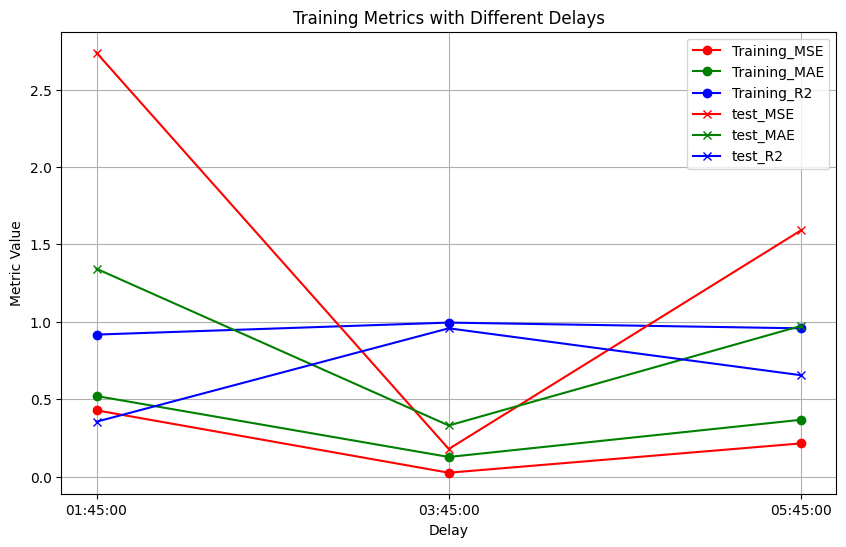

In [80]:
def compare_results(train_results, test_results):
    # Unpack the results into separate lists
    delays, training_mses, training_maes, training_r2s = zip(*train_results)
    delays, test_mses, test_maes, test_r2s = zip(*test_results)
    training_mses = [float(i) for i in training_mses]
    training_maes = [float(i) for i in training_maes]
    training_r2s = [float(i) for i in training_r2s]
    test_mses = [float(i) for i in test_mses]
    test_maes = [float(i) for i in test_maes]
    test_r2s = [float(i) for i in test_r2s]

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(delays, training_mses, marker='o', label='Training_MSE', color='red')
    plt.plot(delays, training_maes, marker='o', label='Training_MAE', color='green')
    plt.plot(delays, training_r2s, marker='o', label='Training_R2', color='blue')
    plt.plot(delays, test_mses, marker='x', label='test_MSE', color='red')
    plt.plot(delays, test_maes, marker='x', label='test_MAE', color='green')
    plt.plot(delays, test_r2s, marker='x', label='test_R2', color='blue')

    # Add labels and legend
    plt.title('Training Metrics with Different Delays')
    plt.xlabel('Delay')
    plt.ylabel('Metric Value')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()

compare_results(train_results, test_results)

#  we can firstly say that a delay of 3:45:00 is the best choice among these 3 possibilities
delay = '03:45:00'

In [81]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

training_dataset = get_input_df(delay, df_input, df_target)
x_train, y_train, x_test, y_test = split_dataset(training_dataset)

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
rf = grid_search.best_estimator_
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)
mse_train, mae_train, r2_train = metrics(y_train, y_pred_train)
mse_test, mae_test, r2_test = metrics(y_test, y_pred_test)
train_results.append([delay, mse_train, mae_train, r2_train])
test_results.append([delay, mse_test, mae_test, r2_test])
print("mse_train: ", mse_train)
print("mae_train: ", mae_train)
print("r2_train: ", r2_train)
print("mse_test: ", mse_test)
print("mae_test: ", mae_test)
print("r2_test: ", r2_test)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
0.6713437661854602
mse_train:  0.5734665962835136
mae_train:  0.5988514703037328
r2_train:  0.8879296493018186
mse_test:  1.6241159631136466
mae_test:  0.9756526655252171
r2_test:  0.6480422072832386


In [82]:
#save the model
import pickle
filename = 'rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

Variable: DT_DEMO_Peroxide_mean Importance: 0.47
Variable: DT_DEMO_Inlet_Brightness Importance: 0.19
Variable: DT_DEMO_Soda_mean    Importance: 0.13
Variable: DT_DEMO_Peroxide_std Importance: 0.04
Variable: DT_DEMO_PH_mean      Importance: 0.03
Variable: DT_DEMO_Soda_std     Importance: 0.03
Variable: DT_DEMO_InletPressure_mean Importance: 0.02
Variable: DT_DEMO_Temperature_mean Importance: 0.02
Variable: DT_DEMO_InletPressure_std Importance: 0.02
Variable: DT_DEMO_Temperature_std Importance: 0.02
Variable: DT_DEMO_PH_std       Importance: 0.02


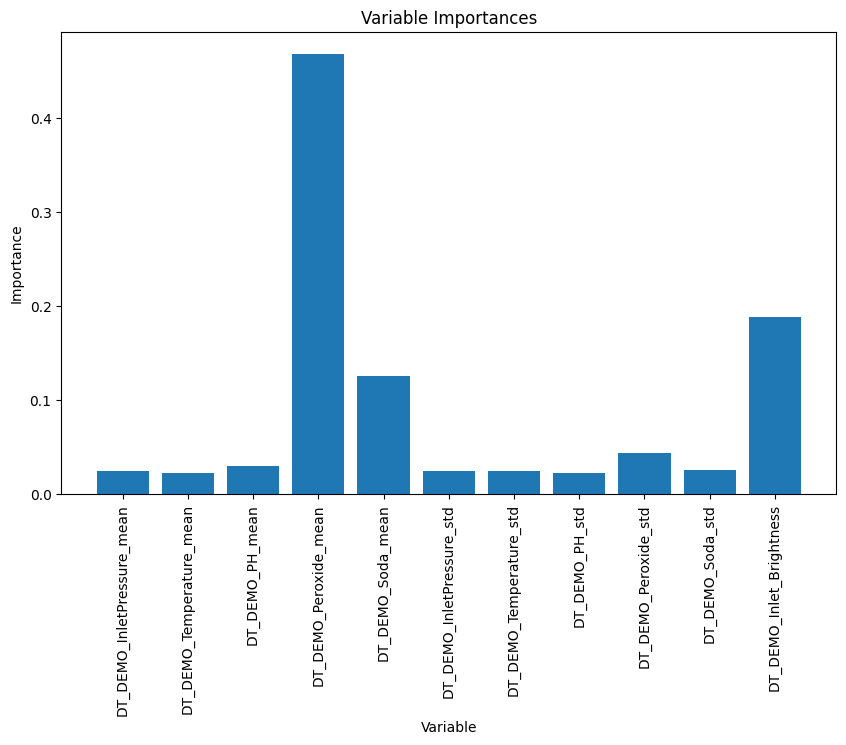

In [83]:
# feature importance
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(x_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))

# plot feature importance
plt.figure(figsize=(10, 6))
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, x_train.columns, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()




In [84]:
delay = propogation_delays[1]
training_dataset = get_input_df(delay, df_input, df_target)
training_dataset = training_dataset[['time_stamp','DT_DEMO_Peroxide_mean', 'DT_DEMO_Soda_mean', 'DT_DEMO_Inlet_Brightness', 'target']]
x_train, y_train, x_test, y_test = split_dataset(training_dataset)
rf, mse_train, mae_train, r2_train, mse_test, mae_test, r2_test = train_rf(x_train, y_train, x_test, y_test)
print("mse_train: ", mse_train)
print("mae_train: ", mae_train)
print("r2_train: ", r2_train)
print("mse_test: ", mse_test)
print("mae_test: ", mae_test)
print("r2_test: ", r2_test)

mse_train:  0.025699218246166087
mae_train:  0.12753929443894477
r2_train:  0.9950592919763194
mse_test:  0.18086473365595632
mae_test:  0.3287545002772505
r2_test:  0.9576555887013818
